# Demonstration

## Basic

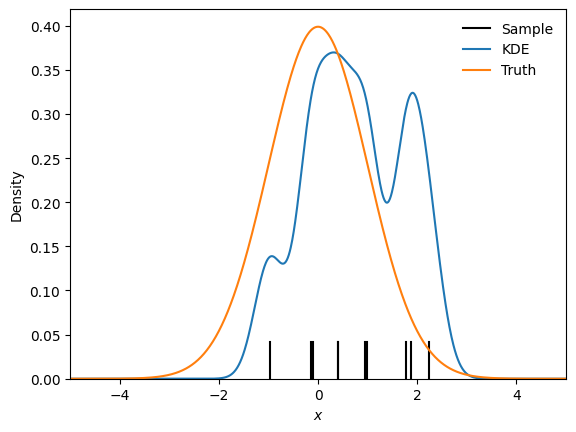

In [4]:
import matplotlib.pyplot as plt
import numpy as np

from scipy.stats import norm

np.random.seed(0)
sample = np.random.normal(size=10)
for i, x in enumerate(sample):
    plt.axvline(x, ymax=0.1, color='black', label='Sample' if i==0 else None)

b = 0.3
dens = lambda x: np.sum([norm.pdf((x - x_i) / b) for x_i in sample]) / (len(sample) * b)

x = np.linspace(-5, +5, 1001)
plt.plot(x, list(map(dens, x)), label='KDE')
plt.plot(x, list(map(norm.pdf, x)), label='Truth')
plt.ylim(ymin=0)
plt.xlim(-5, +5)
plt.legend(loc='best', frameon=False)
plt.xlabel('$x$')
plt.ylabel('Density');

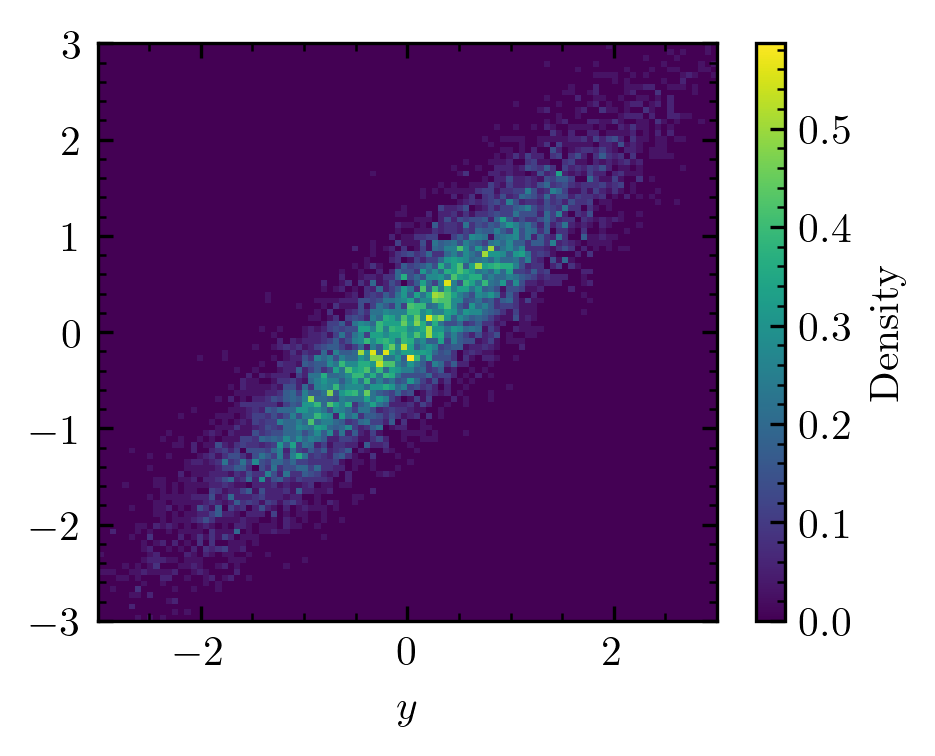

In [2]:
import matplotlib.pyplot as plt
import numpy as np

np.random.seed(42)
X = np.random.multivariate_normal([0, 0], [[1.0, 0.9], [0.9, 1.0]], size=10000)
plt.hist2d(X[:, 0], X[:, 1], bins=np.linspace(-3, +3, 101), density=True)
plt.xlabel('$x$')
plt.xlabel('$y$')
plt.colorbar(label='Density');

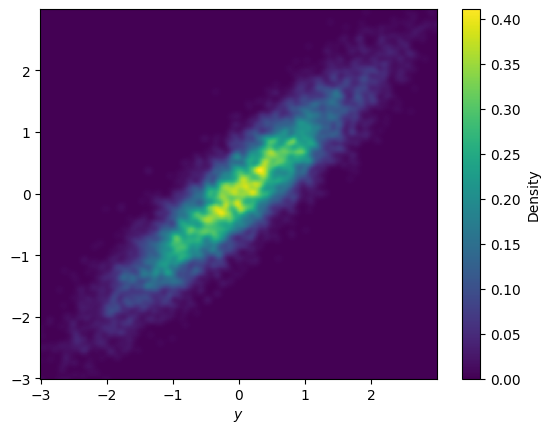

In [7]:
import matplotlib.pyplot as plt
import numpy as np

from sklearn.neighbors import KernelDensity

np.random.seed(42)
X = np.random.multivariate_normal([0, 0], [[1.0, 0.9], [0.9, 1.0]], size=10000)
kde = KernelDensity(bandwidth=0.05, rtol=1e-4).fit(X)
x, y = np.mgrid[-3:3:.01, -3:3:.01]
X = np.column_stack((x.ravel(), y.ravel()))
plt.pcolormesh(x, y, np.exp(kde.score_samples(X).reshape(x.shape)))
plt.xlabel('$x$')
plt.xlabel('$y$')
plt.colorbar(label='Density');

## Selecting Optimal Bandwidth

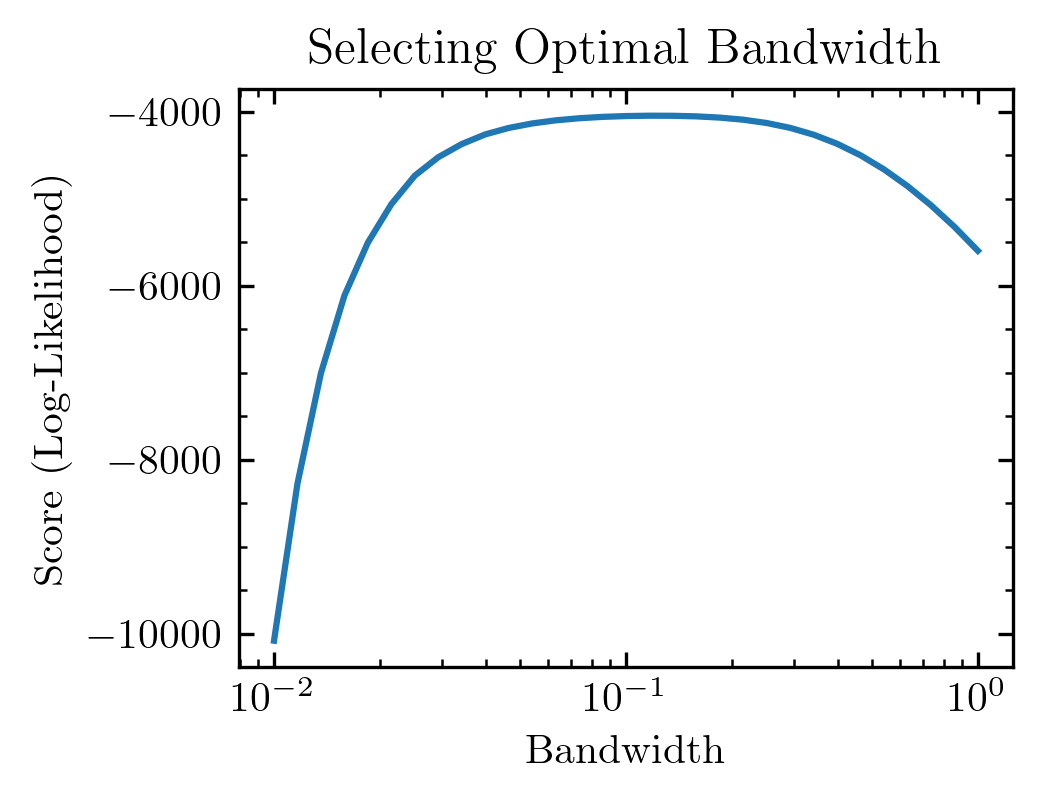

In [4]:
import matplotlib.pyplot as plt
import numpy as np

from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KernelDensity

np.random.seed(42)
X = np.random.multivariate_normal([0, 0], [[1.0, 0.9], [0.9, 1.0]], size=10000)

cv = GridSearchCV(
    KernelDensity(rtol=1e-4), param_grid=dict(bandwidth=np.logspace(-2, 0, 31)),
    n_jobs=-1).fit(X)

plt.plot(cv.cv_results_['param_bandwidth'], cv.cv_results_['mean_test_score'])
plt.xscale('log')
plt.xlabel('Bandwidth')
plt.ylabel('Score (Log-Likelihood)')
plt.title('Selecting Optimal Bandwidth');

## Heterogenous Data

In `sklearn`, the kernel is always homogeneous and isotropic, i.e., the data is smeared in every direction by the same amount. This is not ideal if features have very different ranges or some features are highly correlated.

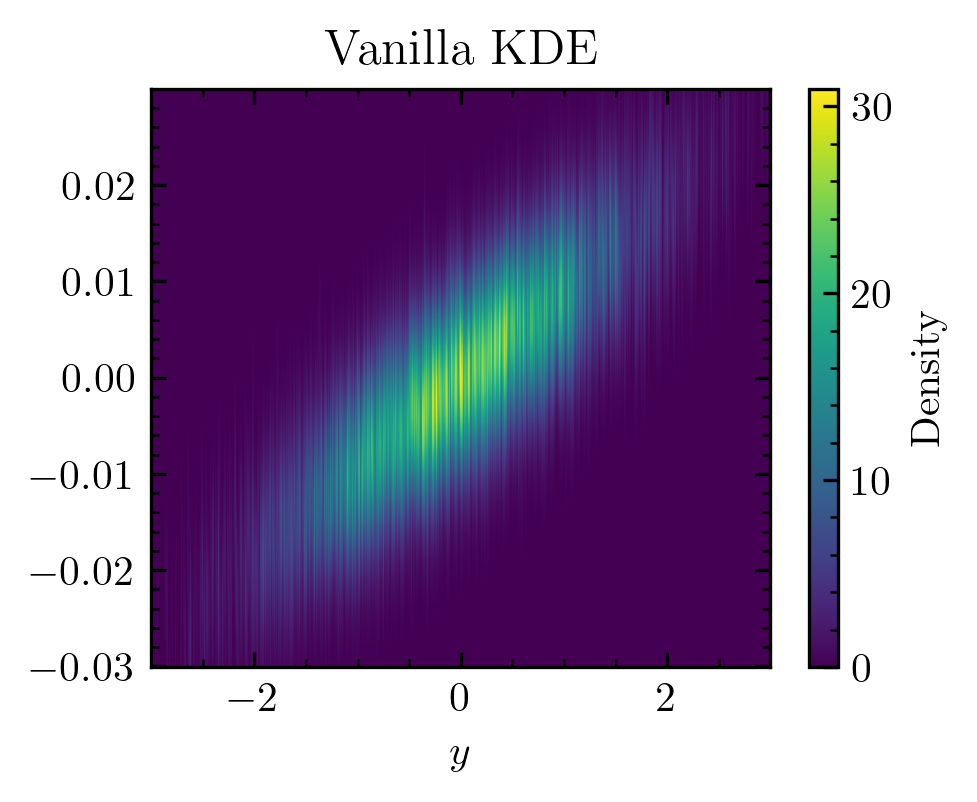

In [5]:
import matplotlib.pyplot as plt
import numpy as np

from sklearn.neighbors import KernelDensity

np.random.seed(42)
X = np.random.multivariate_normal([0, 0], [[1.0, 0.9], [0.9, 1.0]], size=10000)
X[:, 1] *= 0.01
kde = KernelDensity(bandwidth=0.005, rtol=1e-4).fit(X)
x, y = np.mgrid[-3:3:.01, -.03:.03:.0001]
X = np.column_stack((x.ravel(), y.ravel()))
plt.pcolormesh(x, y, np.exp(kde.score_samples(X).reshape(x.shape)))
plt.xlabel('$x$')
plt.xlabel('$y$')
plt.colorbar(label='Density')
plt.title('Vanilla KDE');

We can rectify this problem by first "whitening" the features with PCA such that they all have unit variance and no correlations.

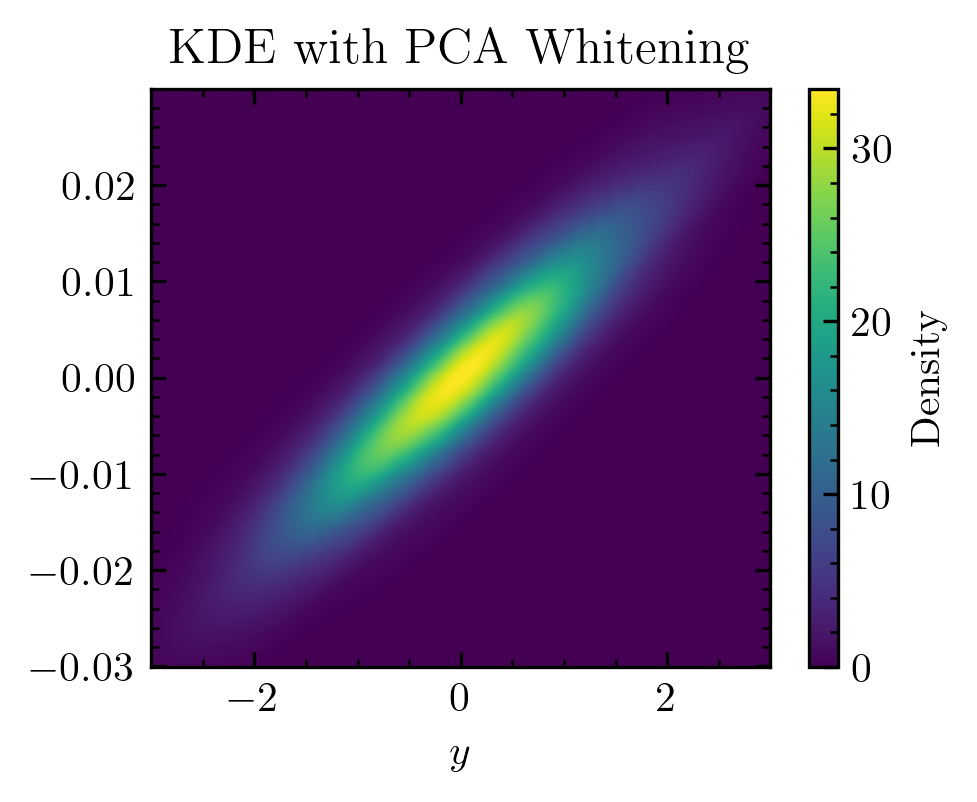

In [6]:
import matplotlib.pyplot as plt
import numpy as np

from sklearn.decomposition import PCA
from sklearn.neighbors import KernelDensity

np.random.seed(42)
X = np.random.multivariate_normal([0, 0], [[1.0, 0.9], [0.9, 1.0]], size=10000)
X[:, 1] *= 0.01
pca = PCA(whiten=True).fit(X)
kde = KernelDensity(bandwidth=0.3, rtol=1e-4).fit(pca.transform(X))
x, y = np.mgrid[-3:3:.01, -.03:.03:.0001]
X = np.column_stack((x.ravel(), y.ravel()))
plt.pcolormesh(
    x, y, np.exp(kde.score_samples(pca.transform(X)).reshape(x.shape)) /
    np.sqrt(np.prod(pca.explained_variance_)))
plt.xlabel('$x$')
plt.xlabel('$y$')
plt.colorbar(label='Density')
plt.title('KDE with PCA Whitening');

# Exercise

For this exercise, we will return to the relation of stellar mass vs. host halo mass for central galaxies. Download the file `Class_3_galaxies.csv` from canvas. The columns of interest are the galaxy type (`type`, should be `central`), the stellar mass (`mstar`) and the host halo mass (`halo_mtot`).

(a) First, make a two-dimensional histogram of the (base-10) logarithms of the host halo mass ($x$-axis) and the stellar mass ($y$-axis) of central galaxies. Use a logarithmic color scale with `matplotlib.colors.LogNorm`.

(b) Now, let's make the same plot with a kernel density estimation (KDE) estimate of the distribution. For now, choose the optimal kernel and bandwidth "by eye".

(c) Finally, find the optimal kernel and bandwidth using cross-validation on the total likelihood. How does the best parameter choice compare to your answer in (b)?

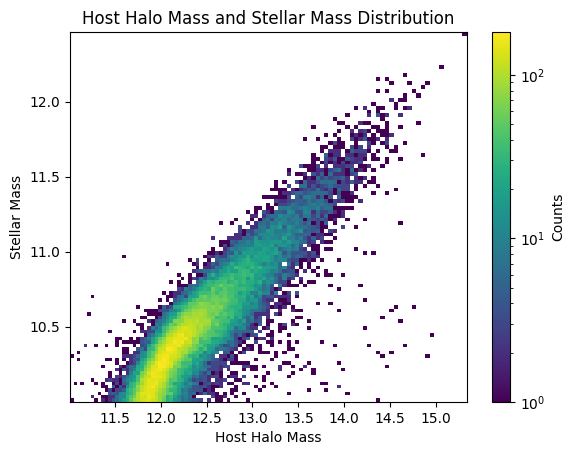

In [13]:
import pandas as pd
from matplotlib import pyplot as plt
from matplotlib.colors import LogNorm
import numpy as np

df = pd.read_csv("Class_3_galaxies.csv")
df = df[df["type"] == 'central']

host_halo_mass = np.log10(df["halo_mtot"])
stellar_mass = np.log10(df["mstar"])
xbins = np.geomspace(min(host_halo_mass), max(host_halo_mass), 100)
ybins = np.geomspace(min(stellar_mass), max(stellar_mass), 100)
plt.title("Host Halo Mass and Stellar Mass Distribution")
plt.xlabel("Host Halo Mass")
plt.ylabel("Stellar Mass")
plt.hist2d(host_halo_mass, stellar_mass, bins = (xbins, ybins), norm = LogNorm())
plt.colorbar(label = 'Counts')
plt.show()

/Users/quinnhelfand/Documents/GitHub/School/ISCI-396/.venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but KernelDensity was fitted with feature names
  warnings.warn(


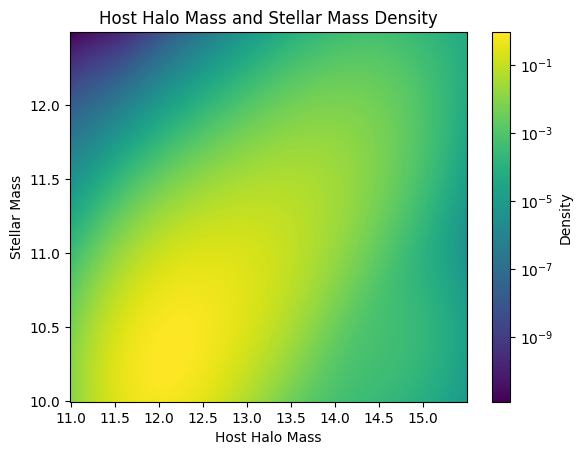

In [36]:
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
from sklearn.neighbors import KernelDensity
from matplotlib.colors import LogNorm


df = pd.read_csv("Class_3_galaxies.csv")
df = df[df["type"] == 'central']
X = pd.DataFrame({'halo_mtot': np.log10(df["halo_mtot"]), 'mstar': np.log10(df["mstar"])})
X = X.dropna()

kde = KernelDensity(bandwidth=0.3, rtol=1e-4).fit(X)
x, y = np.mgrid[11:15.5:.01, 10:12.5:.01]
X = np.column_stack((x.ravel(), y.ravel()))
plt.pcolormesh(x, y, np.exp(kde.score_samples(X).reshape(x.shape)), norm = LogNorm())
plt.title("Host Halo Mass and Stellar Mass Density")
plt.xlabel("Host Halo Mass")
plt.ylabel("Stellar Mass")
plt.colorbar(label='Density')


,param_bandwidth,mean_test_score
0,0.010000,-1.173058e+06
1,0.016379,-4.436730e+05
2,0.026827,-1.722253e+05
3,0.043940,-7.116135e+04
4,0.071969,-3.308368e+04
5,0.117877,-1.830970e+04
6,0.193070,-1.264290e+04
7,0.316228,-1.116534e+04
8,0.517947,-1.299558e+04
9,0.848343,-1.794849e+04


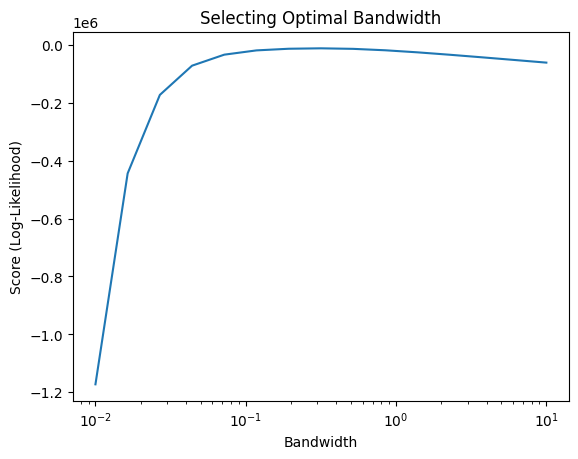

In [19]:
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.model_selection import GridSearchCV
import numpy as np

df = pd.read_csv("Class_3_galaxies.csv")
df = df[df["type"] == 'central']
X = pd.DataFrame({"halo_mtot": np.log10(df["halo_mtot"]), "mstar": np.log10(df["mstar"])})

cv = GridSearchCV(
    KernelDensity(rtol=1e-4), param_grid=dict(bandwidth=np.logspace(-2, 1, 15)),
    n_jobs=-1).fit(X)

plt.plot(cv.cv_results_['param_bandwidth'], cv.cv_results_['mean_test_score'])
plt.xscale('log')
plt.xlabel('Bandwidth')
plt.ylabel('Score (Log-Likelihood)')
plt.title('Selecting Optimal Bandwidth')

results = pd.DataFrame({'param_bandwidth': cv.cv_results_['param_bandwidth'], 'mean_test_score': cv.cv_results_['mean_test_score']})
display(results)